In [3]:
# Numpy
import numpy as np

# OS
import os

# Pytorch related libraries
import torch # for pytorch
import torch.nn as nn # for Core neural network class in pytorch
import torch.optim as optim # for using the inbuilt pytorch optimzation functions
from torch.autograd import Variable 
import torch.nn.functional as F #for using different inbuilt functions of pytorch

# Torchvision
import torchvision 
from torchvision import datasets # for various datasets
import torchvision.transforms as transforms # for dataset transformation

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 # for image manipulation

# cpickle
import _pickle as cPickle

# Set random seed for reproducibility
SEED = 21
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Data Exploration, Preprocessing and transformation

In [4]:
data_transform = transforms.Compose([transforms.RandomHorizontalFlip()
                                      ,transforms.RandomRotation(10)
                                      ,transforms.ToTensor()
                                     ])

In [5]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64,num_workers=0)

Files already downloaded and verified


In [6]:
len(dataset)

50000

In [7]:
def calculate_img_stats(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for imgs,_ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std

In [8]:
cifar10_mean,cifar10_std = calculate_img_stats(loader) # Note : only calculated on train dataset as will be similar for test set

In [9]:
# print(cifar10_mean,cifar10_std)

In [10]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(cifar10_mean, cifar10_std)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(cifar10_mean, cifar10_std)
                                    ])

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
trainset.train_data.shape

(50000, 32, 32, 3)

In [13]:
def load_classes():
    path = './data/cifar-10-batches-py/'
    file = 'batches.meta'
    
    with open(path + file, 'rb') as fin:
        dict = cPickle.load(fin)
        print(dict)
        return dict['label_names']

def print_classes(label_names):
    for i in range(10):
        print(str(i) + " : " + label_names[i])

classes = load_classes()
print_classes(classes)

{'num_vis': 3072, 'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']}
0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck


In [14]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

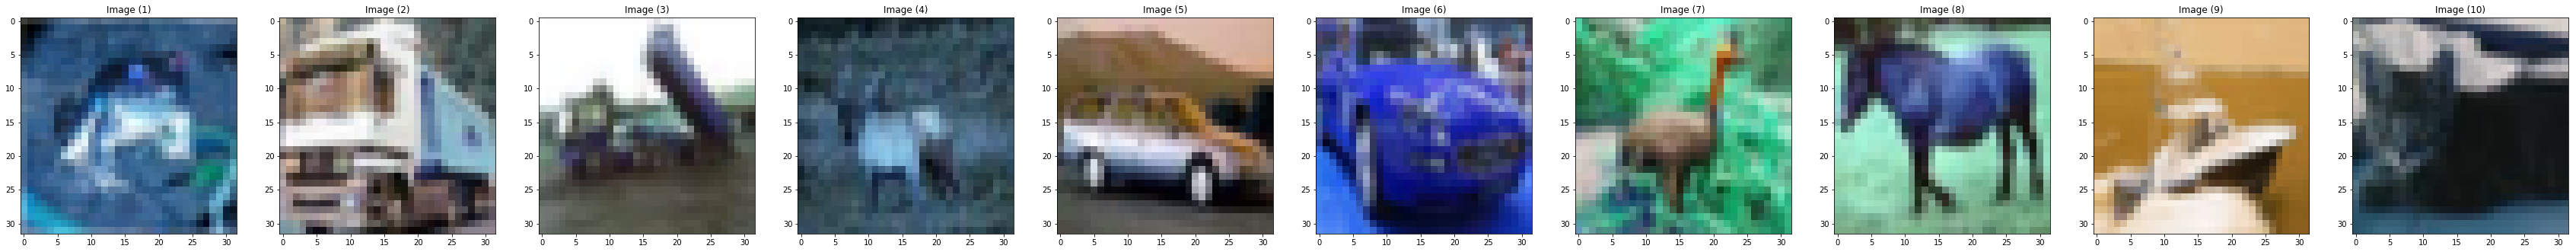

In [15]:
# Shwoing sample images from the train data
show_images(trainset.train_data[0:10])

# Define the Autoencoder model

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # out size : [batch_size, 64, 2, 2]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return encoded, x

# Define the train method and start training

In [15]:
# Moves variable to CUDA
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

In [16]:
def train(model, loss_criterion, num_epochs=5, batch_size=128, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = loss_criterion 
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)    

    outputs = []
    for epoch in range(num_epochs):
        for data in trainloader:
            img, _ = data
            img = get_torch_vars(img)
            _, recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    
    
    print('Finished Training')
    print('Saving Model...')
    if not os.path.exists('./weights'):
        os.mkdir('./weights')
    model_file_name = "model_"+str(loss_criterion)+".pkl"
    torch.save(model.state_dict(), "./weights/" + model_file_name)
    return outputs

In [17]:
def desc_model(encoder, decoder):
    print("==================== Encoder Network ====================")
    print(encoder)
    print("==================== Decoder Network ====================")
    print(decoder)
    print("\n")

In [18]:
def create_model():
    autoencoder = Autoencoder()
    desc_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU.")
    return autoencoder

# Training with BCELoss

In [19]:
model = create_model()
max_epochs = 100
loss_criterion = nn.BCELoss() # Binary cross entropy loss
outputs = train(model, loss_criterion, num_epochs=max_epochs)

==================== Encoder Network ====================
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
)
==================== Decoder Network ====================
Sequential(
  (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (5): Sigmoid()
)


Model moved to GPU.
Epoch:1, Loss:-13.9325
Epoch:2, Loss:-15.3503
Epoch:3, Loss:-16.5549
Epoch:4, Loss:-16.5518
Epoch:5, Loss:-14.7227
Epoch:6, Loss:-16.1490
Epoch:7, Loss:-17.2226
Epoch:8, Loss:-17.1164
Epoch:9, Loss:-16.4919
Epoch:10, Loss:-17.0304
Epoch:11, Loss:-16.4872
Epoch:12, Loss:-16.4320
Epoch

# Visualize the reconstructed results while using BCELoss

In [20]:
testloader = torch.utils.data.DataLoader(testset, batch_size=16,shuffle=False, num_workers=2)

In [28]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Loading checkpoint...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog   cat automobile airplane truck   dog horse truck  ship


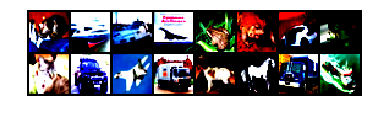

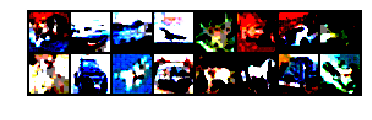

In [22]:
print("Loading checkpoint...")
model_file_name = "model_"+str(loss_criterion)+".pkl"
model.load_state_dict(torch.load("./weights/" + model_file_name))
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images.cuda())

decoded_imgs = model(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

# Training with MSELoss

In [1]:
model = create_model()
max_epochs = 100
loss_criterion = nn.MSELoss() # mean square error loss
outputs = train(model, loss_criterion, num_epochs=max_epochs)

# Visualize the reconstructed results while using MSELoss

Loading checkpoint...


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6be70baf28>>
Traceback (most recent call last):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
  

GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog   cat automobile airplane truck   dog horse truck  ship


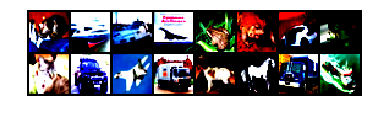

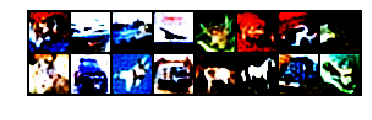

In [24]:
print("Loading checkpoint...")
model_file_name = "model_"+str(loss_criterion)+".pkl"
model.load_state_dict(torch.load("./weights/" + model_file_name))
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images.cuda())

decoded_imgs = model(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   deer   dog truck  bird  deer automobile truck   dog  deer  frog   dog  frog airplane truck   cat truck


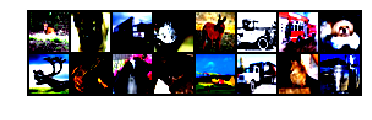

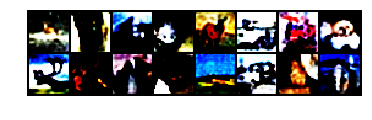

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  horse  frog truck  ship airplane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat


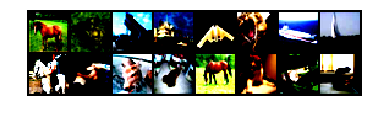

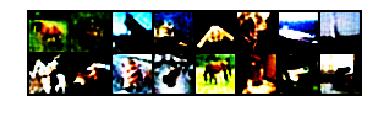

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   frog  bird automobile  bird   cat horse  bird  frog  ship  ship airplane  bird truck   cat   cat  ship


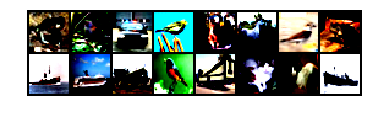

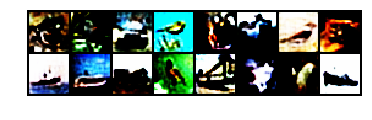

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   ship automobile automobile horse  bird   dog  bird horse  ship truck airplane   cat  ship  frog  deer  frog


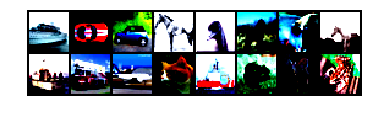

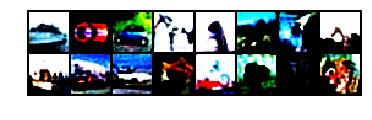

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   frog airplane airplane horse  deer   dog  frog   cat automobile automobile   cat  frog  ship horse  deer airplane


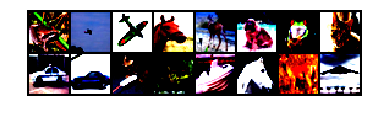

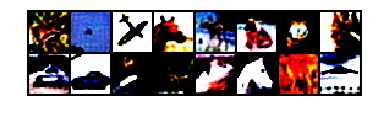

In [31]:
# Plot some five set of reconstructions
for i in range(5):
    images, labels = dataiter.next()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
    imshow(torchvision.utils.make_grid(images))

    images = Variable(images.cuda())

    decoded_imgs = model(images)[1]
    imshow(torchvision.utils.make_grid(decoded_imgs.data))

# After looking at the reconstructed results while using BCELoss and MSELoss, we find that the reconstructions using MSELoss is better looking than that of BCELoss.